*   Nama: Tuti Amalia
*   Email: tutiamalia111@gmail.com
*   Asal: Kabupaten Gowa
*   Dataset yang digunakan: https://www.kaggle.com/abhi8923shriv/cat-dog-dataset

In [1]:
!nvidia-smi

Tue Aug 10 15:00:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
# library
import tensorflow as tf
import numpy as np
import shutil
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential


Download Dataset

In [2]:
from google.colab import files
!pip install -q kaggle

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-08-09 11:16:59          10466  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6394  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2394  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2606  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [7]:
!kaggle datasets download -d abhi8923shriv/cat-dog-dataset

100% 544M/545M [00:04<00:00, 118MB/s]
100% 545M/545M [00:04<00:00, 128MB/s]


In [8]:
# melakukan ekstraksi pada file zip
import zipfile,os
fileZip = 'cat-dog-dataset.zip'
zipRef = zipfile.ZipFile(fileZip, 'r')
zipRef.extractall('/content')
zipRef.close()

In [9]:
# melihat total gambar pada masing2 folder
base_dir = '/content/Cat_Dog_data/train/'
class_dir = ['cat', 'dog']

for i in class_dir:
    print('Total gambar {} : '.format(i) + str(len(os.listdir(base_dir + i + '/'))))

Total gambar cat : 11250
Total gambar dog : 11250


Menampilkan gambar

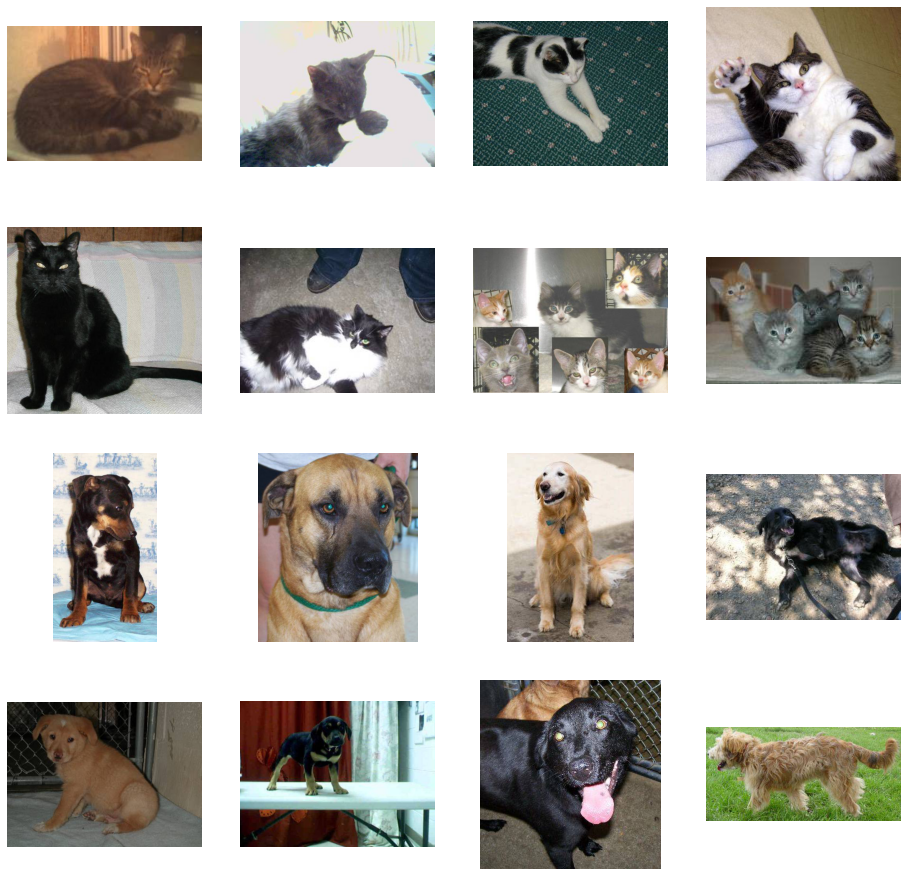

In [10]:
train_cats_dir = '/content/Cat_Dog_data/train/cat'
train_dogs_dir = '/content/Cat_Dog_data/train/dog'
train_cat_names = os.listdir(train_cats_dir)
train_dog_names = os.listdir(train_dogs_dir)
nrows = 4
ncols = 4

pic_index = 0
pic_index += 8
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

next_cat_pix = [os.path.join(train_cats_dir, n) 
                for n in train_cat_names[pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, n) 
                for n in train_dog_names[pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):

  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [11]:
# membuat nama direktori
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir, 'val')

# membuat direktori train dan validation
os.makedirs(train_dir, exist_ok = True)
os.makedirs(val_dir, exist_ok = True)

In [12]:
from sklearn.model_selection import train_test_split
import shutil
# untuk memisahkan training set dan validation set
for i in class_dir:
  train_file_names, val_file_names =  train_test_split(os.listdir(os.path.join(base_dir, i)), test_size = 0.2)
  train_class_dir = os.path.join(train_dir, i)
  val_class_dir = os.path.join(val_dir, i)

  # Jika folder ini ada, hapus isinya supaya tidak terjadi penumpukan data ketika dieksekusi berkali2
  if os.path.exists(train_class_dir):
    shutil.rmtree(train_class_dir)

  if os.path.exists(val_class_dir):
    shutil.rmtree(val_class_dir)

  # buat folder baru
  os.makedirs(train_class_dir, exist_ok = True)
  os.makedirs(val_class_dir, exist_ok = True)
  
  # copy isinya dari folder lama ke folder baru
  for tfn in train_file_names:
    shutil.copy(os.path.join(base_dir + i, tfn), train_class_dir)

  for vfn in val_file_names:
    shutil.copy(os.path.join(base_dir + i, vfn), val_class_dir)

  #melihat jumlah masing2 kelas untuk train dan validation
  print('Gambar untuk train {} : {}'.format(i,str(len(os.listdir(train_class_dir)))))
  print('Gambar untuk validasi {} : {}'.format(i,str(len(os.listdir(val_class_dir)))))
  print('\n')

Gambar untuk train cat : 9000
Gambar untuk validasi cat : 2250


Gambar untuk train dog : 9000
Gambar untuk validasi dog : 2250




In [13]:
# implementasi image data generator untuk augmentasi gambar
trainDatagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

testDatagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Augmentasi gambar
size = 128
train_generator = trainDatagen.flow_from_directory(
        train_dir,
        target_size = (224, 224),
        batch_size = size,
        class_mode = 'binary')
  
validation_generator = testDatagen.flow_from_directory(
        val_dir,
        target_size = (224, 224),
        batch_size = size,
        shuffle = False,
        class_mode = 'binary')
num_train = train_generator.n
num_val = validation_generator.n
print(num_train)
print(num_val)

Found 18000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.
18000
4500


Membuat dan Melatih Model menggunakan MobileNetV2

In [25]:
MobNet = MobileNetV2(include_top=False, input_shape=(224,224,3))
MobNet.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [35]:
model = Sequential()

model.add(MobNet)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)          737344    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 2,995,585
Trainable params: 737,601
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
# Compile the model
print('Compiling Model.......')
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [38]:
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2)

In [39]:
import datetime
start = datetime.datetime.now()

history = model.fit(train_generator,
        steps_per_epoch=num_train // size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps= num_val // size, 
        callbacks = [callbacks],
        verbose=1)

end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/20
140/140 [==============================] - 272s 2s/step - loss: 0.1515 - accuracy: 0.9391 - val_loss: 0.0690 - val_accuracy: 0.9752
Epoch 2/20
140/140 [==============================] - 267s 2s/step - loss: 0.1027 - accuracy: 0.9592 - val_loss: 0.0699 - val_accuracy: 0.9719
Epoch 3/20
140/140 [==============================] - 266s 2s/step - loss: 0.0898 - accuracy: 0.9636 - val_loss: 0.0481 - val_accuracy: 0.9801
Epoch 4/20
140/140 [==============================] - 265s 2s/step - loss: 0.0879 - accuracy: 0.9654 - val_loss: 0.0503 - val_accuracy: 0.9797
Epoch 5/20
140/140 [==============================] - 263s 2s/step - loss: 0.0826 - accuracy: 0.9659 - val_loss: 0.0507 - val_accuracy: 0.9790
Time:  0:25:00.222471


Plotting Akurasi dan Loss

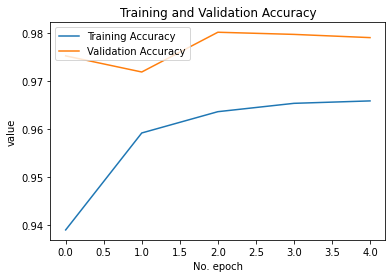

In [40]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

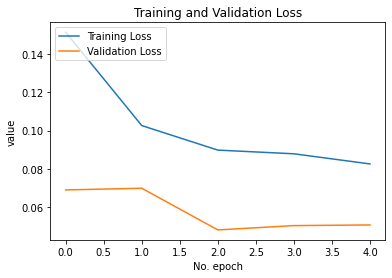

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

Simpan TF-Lite

In [51]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp43zn8cxc/assets


INFO:tensorflow:Assets written to: /tmp/tmp43zn8cxc/assets


In [52]:
with tf.io.gfile.GFile('cat_dog_image_classification.tflite', 'wb') as f:
  f.write(tflite_model)

Simpan model

In [53]:
model.save('cats_and_dogs.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
